In [1]:
import math
import numpy as np
import os
from collections import defaultdict
import scipy.stats as stats
import matplotlib.pyplot as plt
import random as nd
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


# Setup & helper functions

In [2]:
class Data :
    def __init__(self, inputfile) :
        self.data = self.construct_array(inputfile)
        self.num_games = self.data[-1][0]

    def construct_array (self, inputfile) :
        data = open(inputfile, 'r')
        ndtype = [('game-number', 'int'),
                  ('clock', 'int'),
                  ('high-payoff-location', 'a10'),
                  ('player', 'a5'),
                  ('xcor', 'f8'),
                  ('ycor', 'f8'),
                  ('heading', 'f8'),
                  ('points-earned', 'int'),
                  ('noise', 'f8')]
        strucArray = genfromtxt(data, dtype = ndtype, delimiter = ',')
        return strucArray

    def get_data (self) :
        return self.data

In [3]:
def get_blue_data (data) :
    b = data['player'] == 'host'
    return data[b]

def get_red_data (data) :
    b = data['player'] == 'other'
    return data[b]

def get_game_data (data, game_number) :
    b = data['gamenumber'] == game_number
    return data[b]

In [4]:
def get_outcome_seq(conflict_level, who, cond) :
    max_points = 4 if conflict_level == 'high' else 2
    big_list = []
    for r,d,f in os.walk('../data/{0}_{1}_{2}/completed'.format(conflict_level, who, cond)):
        for files in f:
            if files.startswith('game_'):
                ts = []
                destination = r + '/' + files
                d = Data(destination).get_data()
                num_games = d[-1][0]
                red_data, blue_data = get_red_data(d), get_blue_data(d)
                #print red_data
                #print blue_data
                red_points, blue_points = 0, 0                                                                                  
                for i in range(1,num_games+1) :
                    g = get_game_data(d,i)
                    #print "get_red_data(g)[0][-2]", get_red_data(g)[0][-2]
                    #print "get_red_data(g)[-1][-2]", get_red_data(g)[-1][-2]
                    #print get_red_data(g)[0][-2]
                    #print get_red_data(g)[-1][-2] - max_points
                    if get_red_data(g)[0][-2] == get_red_data(g)[-1][-2] - max_points :
                        ts.append('R')
                    elif get_blue_data(g)[0][-2] == get_blue_data(g)[-1][-2] - max_points :
                        ts.append('B')
                    else :
                        ts.append('T')
                big_list.append(ts)
                #print big_list
    return big_list

# Import data

Select the HUMAN data you want to import:

In [5]:
h_human_dyn = get_outcome_seq("high", "human", "dynamic")
#h_human_rea = get_outcome_seq("high", "human", "reactive")
h_human_bal = get_outcome_seq("high", "human", "ballistic")
l_human_dyn = get_outcome_seq("low", "human", "dynamic")
#l_human_rea = get_outcome_seq("low", "human", "reactive")
l_human_bal = get_outcome_seq("low", "human", "ballistic")

Check how many dyads we have for each condition:

In [6]:
print "1 vs. 4 human dynamic:\t", len(h_human_dyn)
#print "1 vs. 4 human reactive:\t", len(h_human_rea)
print "1 vs. 4 human ballistic:", len(h_human_bal)
print "1 vs. 2 human dynamic:\t", len(l_human_dyn)
#print "1 vs. 2 human reactive:\t", len(l_human_rea)
print "1 vs. 2 human ballistic:", len(l_human_bal)

1 vs. 4 human dynamic:	69
1 vs. 4 human ballistic: 56
1 vs. 2 human dynamic:	46
1 vs. 2 human ballistic: 52


Select the MODEL data you want to import:

In [7]:
h_model_dyn = get_outcome_seq("high", "model", "dynamic")
#h_model_rea = get_outcome_seq("high", "model", "reactive")
h_model_bal = get_outcome_seq("high", "model", "ballistic")
l_model_dyn = get_outcome_seq("low", "model", "dynamic")
#l_model_rea = get_outcome_seq("low", "model", "reactive")
l_model_bal = get_outcome_seq("low", "model", "ballistic")

Check how many dyads we have for each condition:

In [8]:
print "1 vs. 4 model dynamic:\t", len(h_model_dyn)
#print "1 vs. 4 model reactive:\t", len(h_model_rea)
print "1 vs. 4 model ballistic:", len(h_model_bal)
print "1 vs. 2 model dynamic:\t", len(l_model_dyn)
#print "1 vs. 2 model reactive:\t", len(l_model_rea)
print "1 vs. 2 model ballistic:", len(l_model_bal)

1 vs. 4 model dynamic:	50
1 vs. 4 model ballistic: 50
1 vs. 2 model dynamic:	50
1 vs. 2 model ballistic: 50


# Efficiency & Fairness analyses

Given the outcome sequence for a given condition, we can compute the efficiency and fairness for each game

In [9]:
def get_efficiency_fairness(outcome_seq) :
    efficiency, fairness = [], []
    # Technically doesn't matter what number we plug in 
    # as long as we normalize correctly, but just to be clear...
    if (len(outcome_seq[0]) == 50) :
        win_payoff = 4 # Set winning payoff as 4 in 'high' condition
    else :
        win_payoff = 2 # Set winning payoff as 2 in 'low' condition
    lose_payoff = 1
    for ts in outcome_seq :
        total_red, total_blue = 0,0
        f_red, f_blue = 0,0
        for element in ts :
            if element == 'R' :
                total_red += win_payoff
                total_blue += lose_payoff
                f_red += 1
            elif element == 'B' :
                total_blue += win_payoff
                total_red += lose_payoff
                f_blue += 1
        # Correct so no dividing by zero (i.e. special case: perfectly fair if they tied every time)...
        if (f_red == 0 and f_blue == 0):
            f_red, f_blue = 1, 1
        efficiency.append((total_red + total_blue) 
                          / ((win_payoff+lose_payoff) * float(len(ts))))
        fairness.append(min(f_red, f_blue) / float(max(f_red, f_blue)))
    return efficiency, fairness 

Compute efficiency and fairness

In [10]:
#For HUMAN DATA

h_human_dyn_eff, h_human_dyn_fair = get_efficiency_fairness(h_human_dyn)
#h_human_rea_eff, h_human_rea_fair = get_efficiency_fairness(h_human_rea)
h_human_bal_eff, h_human_bal_fair = get_efficiency_fairness(h_human_bal)

l_human_dyn_eff, l_human_dyn_fair = get_efficiency_fairness(l_human_dyn)
#l_human_rea_eff, l_human_rea_fair = get_efficiency_fairness(l_human_rea)
l_human_bal_eff, l_human_bal_fair = get_efficiency_fairness(l_human_bal)


In [11]:
#For MODEL DATA

h_model_dyn_eff, h_model_dyn_fair = get_efficiency_fairness(h_model_dyn)
#h_model_rea_eff, h_model_rea_fair = get_efficiency_fairness(h_model_rea)
h_model_bal_eff, h_model_bal_fair = get_efficiency_fairness(h_model_bal)

l_model_dyn_eff, l_model_dyn_fair = get_efficiency_fairness(l_model_dyn)
#l_model_rea_eff, l_model_rea_fair = get_efficiency_fairness(l_model_rea)
l_model_bal_eff, l_model_bal_fair = get_efficiency_fairness(l_model_bal)


Next, we make an interaction plot comparing mean EFFICIENCY across the SIX conditions, first with the HUMAN data:

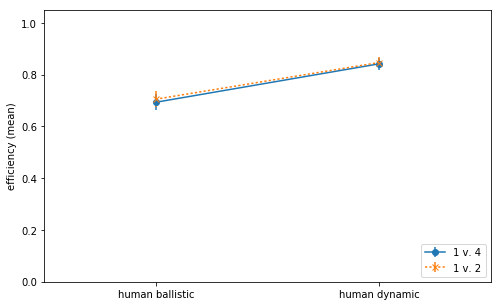

In [12]:
plt.errorbar([0,1], [np.mean(h_human_bal_eff), np.mean(h_human_dyn_eff)], 
             yerr = [np.std(h_human_bal_eff) / math.sqrt(len(h_human_bal_eff)),
                     np.std(h_human_dyn_eff) / math.sqrt(len(h_human_dyn_eff))], 
             fmt='-o',  label = "1 v. 4")
plt.errorbar([0,1], [np.mean(l_human_bal_eff), np.mean(l_human_dyn_eff)], 
             yerr = [np.std(l_human_bal_eff) / math.sqrt(len(l_human_bal_eff)),
                     np.std(l_human_dyn_eff) / math.sqrt(len(l_human_dyn_eff))], 
             fmt = ':x', label = "1 v. 2")
plt.xticks([0,1],['human ballistic', 'human dynamic'])
plt.xlim(-0.5, 1.5)
plt.ylim(0.00, 1.05)
plt.legend(loc='lower right')
plt.ylabel("efficiency (mean)")

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8,5)
plt.savefig("../data/figures/Human_Efficiency_Fig.tiff", bbox_inches='tight')

Now, with the MODEL data:

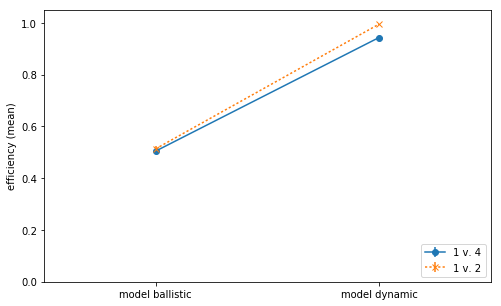

In [13]:
plt.errorbar([0,1], [np.mean(h_model_bal_eff), np.mean(h_model_dyn_eff)], 
             yerr = [np.std(h_model_bal_eff) / math.sqrt(len(h_model_bal_eff)),
                     np.std(h_model_dyn_eff) / math.sqrt(len(h_model_dyn_eff))], 
             fmt='-o',  label = "1 v. 4")
plt.errorbar([0,1], [np.mean(l_model_bal_eff), np.mean(l_model_dyn_eff)], 
             yerr = [np.std(l_model_bal_eff) / math.sqrt(len(l_model_bal_eff)),
                     np.std(l_model_dyn_eff) / math.sqrt(len(l_model_dyn_eff))], 
             fmt = ':x', label = "1 v. 2")
plt.xticks([0,1],['model ballistic', 'model dynamic'])
plt.xlim(-0.5, 1.5)
plt.ylim(0.00, 1.05)
plt.legend(loc='lower right')
plt.ylabel("efficiency (mean)")

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8,5)
plt.savefig("../data/figures/Model_Efficiency_Fig.tiff", bbox_inches='tight')

BOTH plotted together:

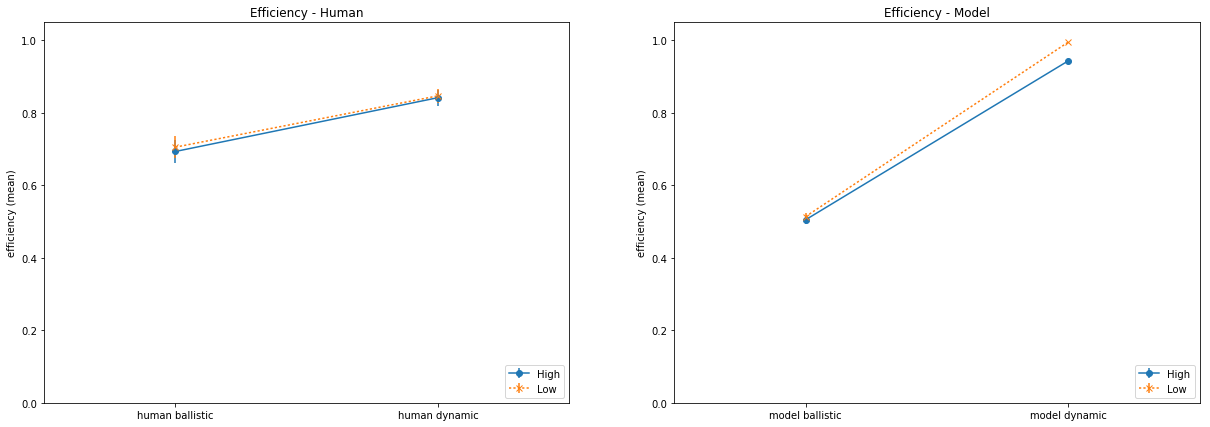

In [14]:
plt.subplot(131)
plt.errorbar([0,1], [np.mean(h_human_bal_eff), np.mean(h_human_dyn_eff)], 
             yerr = [np.std(h_human_bal_eff) / math.sqrt(len(h_human_bal_eff)),
                     np.std(h_human_dyn_eff) / math.sqrt(len(h_human_dyn_eff))], 
             fmt='-o',  label = "High")
plt.errorbar([0,1], [np.mean(l_human_bal_eff), np.mean(l_human_dyn_eff)], 
             yerr = [np.std(l_human_bal_eff) / math.sqrt(len(l_human_bal_eff)),
                     np.std(l_human_dyn_eff) / math.sqrt(len(l_human_dyn_eff))], 
             fmt = ':x', label = "Low")
plt.xticks([0,1],['human ballistic', 'human dynamic'])
plt.xlim(-0.5, 1.5)
plt.ylim(0.00, 1.05)
plt.legend(loc='lower right')
plt.ylabel("efficiency (mean)")
plt.title("Efficiency - Human")


plt.subplot(132)
plt.errorbar([0,1], [np.mean(h_model_bal_eff), np.mean(h_model_dyn_eff)], 
             yerr = [np.std(h_model_bal_eff) / math.sqrt(len(h_model_bal_eff)),
                     np.std(h_model_dyn_eff) / math.sqrt(len(h_model_dyn_eff))], 
             fmt='-o',  label = "High")
plt.errorbar([0,1], [np.mean(l_model_bal_eff), np.mean(l_model_dyn_eff)], 
             yerr = [np.std(l_model_bal_eff) / math.sqrt(len(l_model_bal_eff)),
                     np.std(l_model_dyn_eff) / math.sqrt(len(l_model_dyn_eff))], 
             fmt = ':x', label = "Low")
plt.xticks([0,1],['model ballistic', 'model dynamic'])
plt.xlim(-0.5, 1.5)
plt.ylim(0.00, 1.05)
plt.legend(loc='lower right')
plt.ylabel("efficiency (mean)")
plt.title("Efficiency - Model")


#matplotlib.rcParams.update({'font.size': 10})
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(32,7)
plt.savefig("../data/figures/Compared_Efficiency_Fig.tiff")

Next, we make an interaction plot comparing mean FAIRNESS across the SIX conditions, first with the HUMAN data:

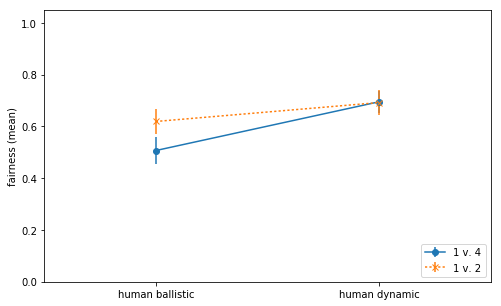

In [15]:
plt.errorbar([0,1], [np.mean(h_human_bal_fair), np.mean(h_human_dyn_fair)], 
             yerr = [np.std(h_human_bal_fair) / math.sqrt(len(h_human_bal_fair)),
                     np.std(h_human_dyn_fair) / math.sqrt(len(h_human_dyn_fair))], 
             fmt='-o',  label = "1 v. 4")
plt.errorbar([0,1], [np.mean(l_human_bal_fair), np.mean(l_human_dyn_fair)], 
             yerr = [np.std(l_human_bal_fair) / math.sqrt(len(l_human_bal_fair)),
                     np.std(l_human_dyn_fair) / math.sqrt(len(l_human_dyn_fair))], 
             fmt = ':x', label = "1 v. 2")
plt.xticks([0,1],['human ballistic', 'human dynamic'])
plt.xlim(-0.5, 1.5)
plt.ylim(0.00, 1.05)
plt.legend(loc='lower right')
plt.ylabel("fairness (mean)")

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8,5)
plt.savefig("../data/figures/Human_Fairness_Fig.tiff", bbox_inches='tight')

Now, with the MODEL data:

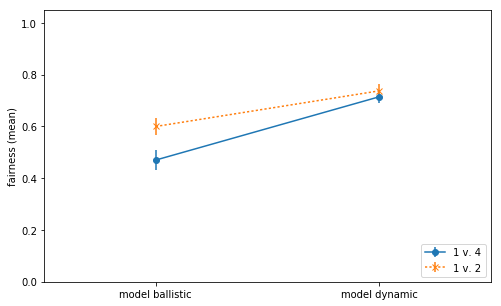

In [16]:
plt.errorbar([0,1], [np.mean(h_model_bal_fair), np.mean(h_model_dyn_fair)], 
             yerr = [np.std(h_model_bal_fair) / math.sqrt(len(h_model_bal_fair)),
                     np.std(h_model_dyn_fair) / math.sqrt(len(h_model_dyn_fair))], 
             fmt='-o',  label = "1 v. 4")
plt.errorbar([0,1], [np.mean(l_model_bal_fair), np.mean(l_model_dyn_fair)], 
             yerr = [np.std(l_model_bal_fair) / math.sqrt(len(l_model_bal_fair)),
                     np.std(l_model_dyn_fair) / math.sqrt(len(l_model_dyn_fair))], 
             fmt = ':x', label = "1 v. 2")
plt.xticks([0,1,2],['model ballistic', 'model dynamic'])
plt.xlim(-0.5, 1.5)
plt.ylim(0.00, 1.05)
plt.legend(loc='lower right')
plt.ylabel("fairness (mean)")

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8,5)
plt.savefig("../data/figures/Model_Fairness_Fig.tiff", bbox_inches='tight')

BOTH plotted together:

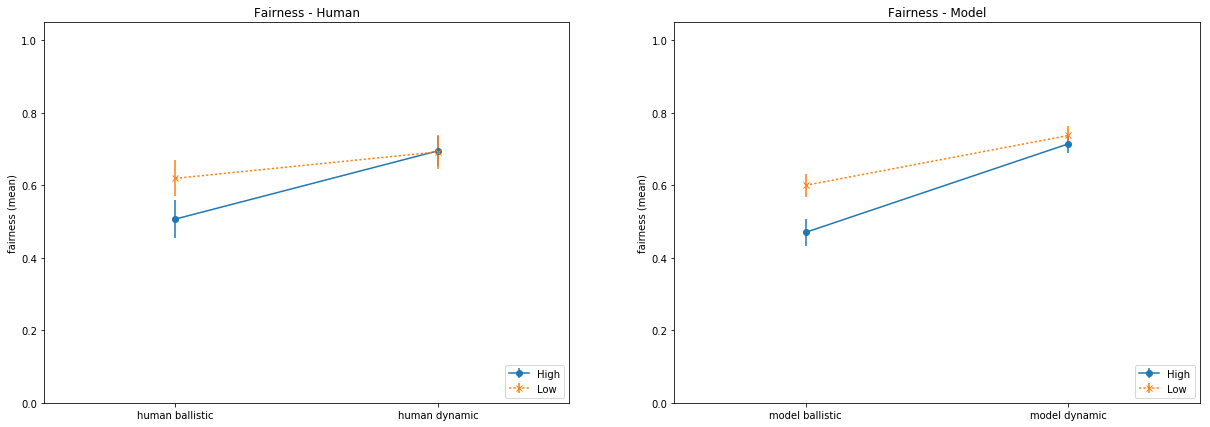

In [17]:
plt.subplot(131)
plt.errorbar([0,1], [np.mean(h_human_bal_fair), np.mean(h_human_dyn_fair)], 
             yerr = [np.std(h_human_bal_fair) / math.sqrt(len(h_human_bal_fair)),
                     np.std(h_human_dyn_fair) / math.sqrt(len(h_human_dyn_fair))], 
             fmt='-o',  label = "High")
plt.errorbar([0,1], [np.mean(l_human_bal_fair), np.mean(l_human_dyn_fair)], 
             yerr = [np.std(l_human_bal_fair) / math.sqrt(len(l_human_bal_fair)),
                     np.std(l_human_dyn_fair) / math.sqrt(len(l_human_dyn_fair))], 
             fmt = ':x', label = "Low")
plt.xticks([0,1],['human ballistic', 'human dynamic'])
plt.xlim(-0.5, 1.5)
plt.ylim(0.00, 1.05)
plt.legend(loc='lower right')
plt.ylabel("fairness (mean)")
plt.title("Fairness - Human")


plt.subplot(132)
plt.errorbar([0,1], [np.mean(h_model_bal_fair), np.mean(h_model_dyn_fair)], 
             yerr = [np.std(h_model_bal_fair) / math.sqrt(len(h_model_bal_fair)),
                     np.std(h_model_dyn_fair) / math.sqrt(len(h_model_dyn_fair))], 
             fmt='-o',  label = "High")
plt.errorbar([0,1], [np.mean(l_model_bal_fair), np.mean(l_model_dyn_fair)], 
             yerr = [np.std(l_model_bal_fair) / math.sqrt(len(l_model_bal_fair)),
                     np.std(l_model_dyn_fair) / math.sqrt(len(l_model_dyn_fair))], 
             fmt = ':x', label = "Low")
plt.xticks([0,1,2],['model ballistic', 'model dynamic'])
plt.xlim(-0.5, 1.5)
plt.ylim(0.00, 1.05)
plt.legend(loc='lower right')
plt.ylabel("fairness (mean)")
plt.title("Fairness - Model")
 

#matplotlib.rcParams.update({'font.size': 25})
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(32,7)
plt.savefig("../data/figures/Compared_Fairness_Fig.tiff")

# Stability

Especially in ballistic conditions, people use the random assignment of the payoffs to coordinate. One player will always go top and the other will always go bottom. The stability of this pattern isn't captured by the outcomes, so we need to check the direction sequence as well.

In [18]:
def get_direction_seq(conflict_level, who, cond) :
    big_list = []
    max_points = 4 if conflict_level == 'high' else 2
    for r,d,f in os.walk('../data/{0}_{1}_{2}/completed'.format(conflict_level, who, cond)):
        for files in f:
            if files.startswith('game_'):
                ts = []
                destination = r + '/' + files
                d = Data(destination).get_data()
                num_games = d[-1][0]
                red_data, blue_data = get_red_data(d), get_blue_data(d)
                for i in range(1,num_games+1) :
                    g = get_game_data(d,i)
                    # If red wins... Count it if they're on top, otherwise note that blue went top
                    if (get_red_data(g)[0][-2] == (get_red_data(g)[-1][-2] - max_points)) :
                        if (get_red_data(g)[0][2]) == 'top' :
                            ts.append('R')
                        else :
                            ts.append('B')
                    # If blue wins... Count it if they're on top, otherwise note that red went top
                    elif (get_blue_data(g)[0][-2] == (get_blue_data(g)[-1][-2] - max_points)) :
                        if (get_blue_data(g)[0][2]) == 'top' :
                            ts.append('B')
                        else :
                            ts.append('R')
                    else :
                        ts.append('T')
                big_list.append(ts)
    return big_list

First compute it for humans and the for our model:

In [19]:
h_human_dyn_dir = get_direction_seq("high", "human", "dynamic")
#h_human_rea_dir = get_direction_seq("high", "human", "reactive")
h_human_bal_dir = get_direction_seq("high", "human", "ballistic")
l_human_dyn_dir = get_direction_seq("low", "human", "dynamic")
#l_human_rea_dir = get_direction_seq("low", "human", "reactive")
l_human_bal_dir = get_direction_seq("low", "human", "ballistic")

In [20]:
h_model_dyn_dir = get_direction_seq("high", "model", "dynamic")
#h_model_rea_dir = get_direction_seq("high", "model", "reactive")
h_model_bal_dir = get_direction_seq("high", "model", "ballistic")
l_model_dyn_dir = get_direction_seq("low", "model", "dynamic")
#l_model_rea_dir = get_direction_seq("low", "model", "reactive")
l_model_bal_dir = get_direction_seq("low", "model", "ballistic")

get_surprise_ts first builds up a conditional probability distribution giving the likelihood of observing one outcome given the previous m outcomes. Once we have this distribution, it computes Shannon's surprisal for each round of the game:

In [21]:
def get_surprise_ts (ts, num_back = 2) :
    d = defaultdict(lambda: defaultdict(int))
    surp = []
    # Build conditional distribution
    for i in range(len(ts) - num_back - 1) :
        substring = ts[i:i+num_back + 1]
        d[''.join(substring[:num_back])][substring[-1]] += 1
    # Compute surprisal (-log(p)) for each time step
    for i in range(len(ts) - num_back - 1) :
        substring = ts[i:i+num_back + 1]
        relevant_d = d[''.join(substring[:num_back])]
        # Add 1/k for virtual counts
        surp.append(-np.log2((relevant_d[substring[-1]] + 1/float(3))/float((sum(relevant_d.values()) + 1))))
    return surp

get_big_surp is a wrapper function for get_surprise_ts. It builds surprisal time series for both the outcome encoding and the direction encoding, then appends the one that is lower overall to the big list of surprisal time series for all dyads in a given condition.

In [22]:
def get_big_surp (outcome_seqs, direction_seqs, num_back = 2) :
    big_surp = []
    dir_counter = 0
    for ts1, ts2 in zip(outcome_seqs, direction_seqs) :
        surp1 = get_surprise_ts(ts1, num_back)
        surp2 = get_surprise_ts(ts2, num_back)
        # Take the surprises of the most stable encoding (I'm being generous to ur strategies)
        if np.median(surp1) < np.median(surp2) :
            big_surp.append(surp1) 
        else :
            dir_counter += 1
            big_surp.append(surp2)
    return big_surp, dir_counter

We calculate the big list of surprisals for each condition:

In [23]:
### Later on, we show that other values of num_back look the same
num_back = 2

h_human_dyn_surp = [image for mi in get_big_surp(h_human_dyn, h_human_dyn_dir, num_back)[0] 
              for image in mi]
h_human_bal_surp = [image for mi in get_big_surp(h_human_bal, h_human_bal_dir, num_back)[0] 
              for image in mi]
l_human_dyn_surp = [image for mi in get_big_surp(l_human_dyn, l_human_dyn_dir, num_back)[0] 
              for image in mi]
l_human_bal_surp = [image for mi in get_big_surp(l_human_bal, l_human_bal_dir, num_back)[0] 
              for image in mi]

In [24]:
### Later on, we show that other values of num_back look the same
num_back = 2

h_model_dyn_surp = [image for mi in get_big_surp(h_model_dyn, h_model_dyn_dir, num_back)[0] 
              for image in mi]
h_model_bal_surp = [image for mi in get_big_surp(h_model_bal, h_model_bal_dir, num_back)[0] 
              for image in mi]
l_model_dyn_surp = [image for mi in get_big_surp(l_model_dyn, l_model_dyn_dir, num_back)[0] 
              for image in mi]
l_model_bal_surp = [image for mi in get_big_surp(l_model_bal, l_model_bal_dir, num_back)[0] 
              for image in mi]

Next, we make an interaction plot comparing mean STABILITY across the SIX conditions, first with the HUMAN data:

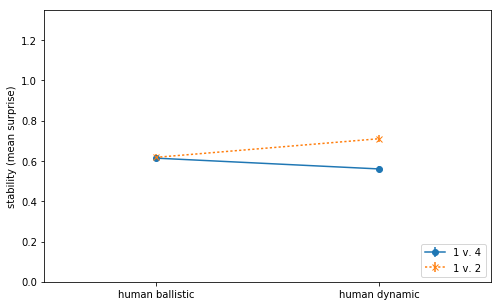

In [25]:
plt.errorbar([0,1], [np.mean(h_human_bal_surp), np.mean(h_human_dyn_surp)], 
             yerr = [np.std(h_human_bal_surp) / math.sqrt(len(h_human_bal_surp)),
                     np.std(h_human_dyn_surp) / math.sqrt(len(h_human_dyn_surp))], 
             fmt='-o',  label = "1 v. 4")
plt.errorbar([0,1], [np.mean(l_human_bal_surp), np.mean(l_human_dyn_surp)], 
             yerr = [np.std(l_human_bal_surp) / math.sqrt(len(l_human_bal_surp)),
                     np.std(l_human_dyn_surp) / math.sqrt(len(l_human_dyn_surp))],
             fmt = ':x', label = "1 v. 2")
plt.xticks([0,1],['human ballistic', 'human dynamic'])
plt.xlim(-0.5, 1.5)
plt.ylim(0.00, 1.35)
plt.legend(loc='lower right')
plt.ylabel("stability (mean surprise)")

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8,5)
plt.savefig("../data/figures/Human_Stability_Fig.tiff", bbox_inches='tight')

Now, with the MODEL data:

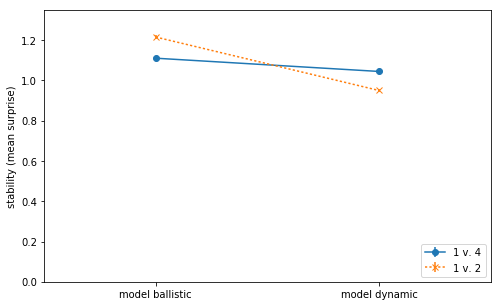

In [26]:
plt.errorbar([0,1], [np.mean(h_model_bal_surp), np.mean(h_model_dyn_surp)], 
             yerr = [np.std(h_model_bal_surp) / math.sqrt(len(h_model_bal_surp)),
                     np.std(h_model_dyn_surp) / math.sqrt(len(h_model_dyn_surp))], 
             fmt='-o',  label = "1 v. 4")
plt.errorbar([0,1], [np.mean(l_model_bal_surp), np.mean(l_model_dyn_surp)], 
             yerr = [np.std(l_model_bal_surp) / math.sqrt(len(l_model_bal_surp)),
                     np.std(l_model_dyn_surp) / math.sqrt(len(l_model_dyn_surp))],
             fmt = ':x', label = "1 v. 2")
plt.xticks([0,1],['model ballistic', 'model dynamic'])
plt.xlim(-0.5, 1.5)
plt.ylim(0.00, 1.35)
plt.legend(loc='lower right')
plt.ylabel("stability (mean surprise)")

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8,5)
plt.savefig("../data/figures/Model_Stability_Fig.tiff", bbox_inches='tight')

BOTH plotted together:

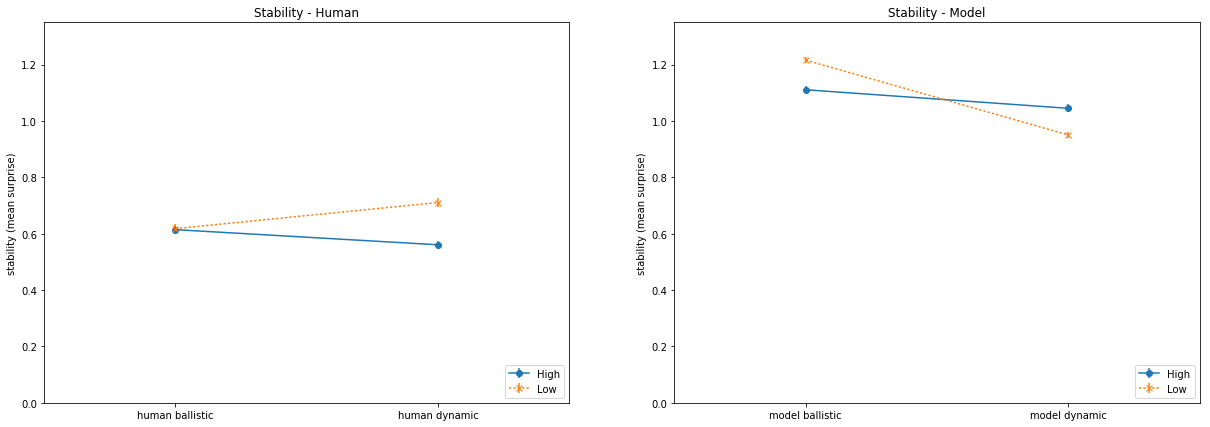

In [27]:
plt.subplot(131)
plt.errorbar([0,1], [np.mean(h_human_bal_surp), np.mean(h_human_dyn_surp)], 
             yerr = [np.std(h_human_bal_surp) / math.sqrt(len(h_human_bal_surp)),
                     np.std(h_human_dyn_surp) / math.sqrt(len(h_human_dyn_surp))], 
             fmt='-o',  label = "High")
plt.errorbar([0,1], [np.mean(l_human_bal_surp), np.mean(l_human_dyn_surp)], 
             yerr = [np.std(l_human_bal_surp) / math.sqrt(len(l_human_bal_surp)),
                     np.std(l_human_dyn_surp) / math.sqrt(len(l_human_dyn_surp))],
             fmt = ':x', label = "Low")
plt.xticks([0,1],['human ballistic', 'human dynamic'])
plt.xlim(-0.5, 1.5)
plt.ylim(0.00, 1.35)
plt.legend(loc='lower right')
plt.ylabel("stability (mean surprise)")
plt.title("Stability - Human")


plt.subplot(132)
plt.errorbar([0,1], [np.mean(h_model_bal_surp), np.mean(h_model_dyn_surp)], 
             yerr = [np.std(h_model_bal_surp) / math.sqrt(len(h_model_bal_surp)),
                     np.std(h_model_dyn_surp) / math.sqrt(len(h_model_dyn_surp))], 
             fmt='-o',  label = "High")
plt.errorbar([0,1], [np.mean(l_model_bal_surp), np.mean(l_model_dyn_surp)], 
             yerr = [np.std(l_model_bal_surp) / math.sqrt(len(l_model_bal_surp)),
                     np.std(l_model_dyn_surp) / math.sqrt(len(l_model_dyn_surp))],
             fmt = ':x', label = "Low")
plt.xticks([0,1],['model ballistic', 'model dynamic'])
plt.xlim(-0.5, 1.5)
plt.ylim(0.00, 1.35)
plt.legend(loc='lower right')
plt.ylabel("stability (mean surprise)")
plt.title("Stability - Model")
 

#matplotlib.rcParams.update({'font.size': 25})
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(32,7)
plt.savefig("../data/figures/Compared_Stability_Fig.tiff")

# Human Data - All together

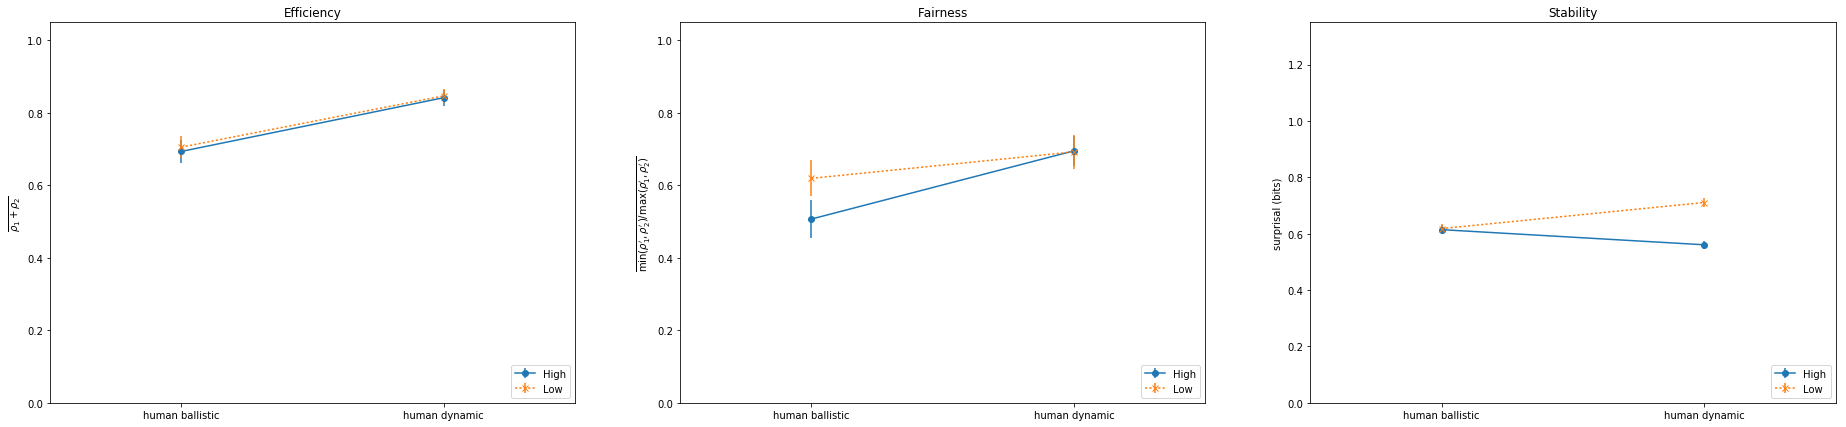

In [28]:
plt.subplot(131)
plt.errorbar([0,1], [np.mean(h_human_bal_eff), np.mean(h_human_dyn_eff)], 
             yerr = [np.std(h_human_bal_eff) / math.sqrt(len(h_human_bal_eff)),
                     np.std(h_human_dyn_eff) / math.sqrt(len(h_human_dyn_eff))], 
             fmt='-o',  label = "High")
plt.errorbar([0,1], [np.mean(l_human_bal_eff), np.mean(l_human_dyn_eff)], 
             yerr = [np.std(l_human_bal_eff) / math.sqrt(len(l_human_bal_eff)),
                     np.std(l_human_dyn_eff) / math.sqrt(len(l_human_dyn_eff))], 
             fmt = ':x', label = "Low")
plt.xticks([0,1],['human ballistic', 'human dynamic'])
plt.xlim(-0.5, 1.5)
plt.ylim(0.00, 1.05)
plt.legend(loc='lower right')
plt.ylabel(r"$\overline{\rho_1 + \rho_2}$")
plt.title("Efficiency")


plt.subplot(132)
plt.errorbar([0,1], [np.mean(h_human_bal_fair), np.mean(h_human_dyn_fair)], 
             yerr = [np.std(h_human_bal_fair) / math.sqrt(len(h_human_bal_fair)),
                     np.std(h_human_dyn_fair) / math.sqrt(len(h_human_dyn_fair))], 
             fmt='-o',  label = "High")
plt.errorbar([0,1], [np.mean(l_human_bal_fair), np.mean(l_human_dyn_fair)], 
             yerr = [np.std(l_human_bal_fair) / math.sqrt(len(l_human_bal_fair)),
                     np.std(l_human_dyn_fair) / math.sqrt(len(l_human_dyn_fair))], 
             fmt = ':x', label = "Low")
plt.xticks([0,1],['human ballistic', 'human dynamic'])
plt.xlim(-0.5, 1.5)
plt.ylim(0.00, 1.05)
plt.legend(loc='lower right')
plt.ylabel(r"$\overline{\min(\rho_1', \rho_2') / \max(\rho_1', \rho_2')}$")
plt.title("Fairness")


plt.subplot(133)
plt.errorbar([0,1], [np.mean(h_human_bal_surp), np.mean(h_human_dyn_surp)], 
             yerr = [np.std(h_human_bal_surp) / math.sqrt(len(h_human_bal_surp)),
                     np.std(h_human_dyn_surp) / math.sqrt(len(h_human_dyn_surp))], 
             fmt='-o',  label = "High")
plt.errorbar([0,1], [np.mean(l_human_bal_surp), np.mean(l_human_dyn_surp)], 
             yerr = [np.std(l_human_bal_surp) / math.sqrt(len(l_human_bal_surp)),
                     np.std(l_human_dyn_surp) / math.sqrt(len(l_human_dyn_surp))],
             fmt = ':x', label = "Low")
plt.xticks([0,1],['human ballistic', 'human dynamic'])
plt.xlim(-0.5, 1.5)
plt.ylim(0.00, 1.35)
plt.legend(loc='lower right')
plt.ylabel(r"surprisal (bits)")
plt.title("Stability")


#matplotlib.rcParams.update({'font.size': 25})
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(32,7)
plt.savefig("../data/figures/Human_All.tiff")

# Model Data - All together

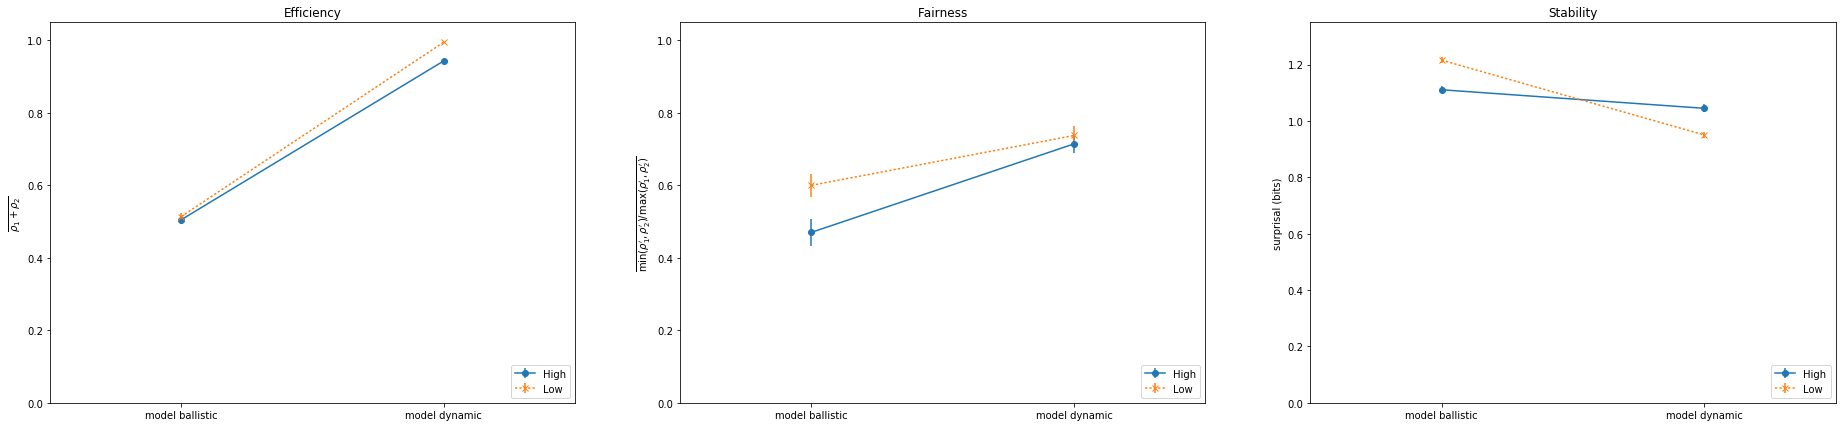

In [29]:
plt.subplot(131)
plt.errorbar([0,1], [np.mean(h_model_bal_eff), np.mean(h_model_dyn_eff)], 
             yerr = [np.std(h_model_bal_eff) / math.sqrt(len(h_model_bal_eff)),
                     np.std(h_model_dyn_eff) / math.sqrt(len(h_model_dyn_eff))], 
             fmt='-o',  label = "High")
plt.errorbar([0,1], [np.mean(l_model_bal_eff), np.mean(l_model_dyn_eff)], 
             yerr = [np.std(l_model_bal_eff) / math.sqrt(len(l_model_bal_eff)),
                     np.std(l_model_dyn_eff) / math.sqrt(len(l_model_dyn_eff))], 
             fmt = ':x', label = "Low")
plt.xticks([0,1],['model ballistic', 'model dynamic'])
plt.xlim(-0.5, 1.5)
plt.ylim(0.00, 1.05)
plt.legend(loc='lower right')
plt.ylabel(r"$\overline{\rho_1 + \rho_2}$")
plt.title("Efficiency")


plt.subplot(132)
plt.errorbar([0,1], [np.mean(h_model_bal_fair), np.mean(h_model_dyn_fair)], 
             yerr = [np.std(h_model_bal_fair) / math.sqrt(len(h_model_bal_fair)),
                     np.std(h_model_dyn_fair) / math.sqrt(len(h_model_dyn_fair))], 
             fmt='-o',  label = "High")
plt.errorbar([0,1], [np.mean(l_model_bal_fair), np.mean(l_model_dyn_fair)], 
             yerr = [np.std(l_model_bal_fair) / math.sqrt(len(l_model_bal_fair)),
                     np.std(l_model_dyn_fair) / math.sqrt(len(l_model_dyn_fair))], 
             fmt = ':x', label = "Low")
plt.xticks([0,1],['model ballistic', 'model dynamic'])
plt.xlim(-0.5, 1.5)
plt.ylim(0.00, 1.05)
plt.legend(loc='lower right')
plt.ylabel(r"$\overline{\min(\rho_1', \rho_2') / \max(\rho_1', \rho_2')}$")
plt.title("Fairness")


plt.subplot(133)
plt.errorbar([0,1], [np.mean(h_model_bal_surp), np.mean(h_model_dyn_surp)], 
             yerr = [np.std(h_model_bal_surp) / math.sqrt(len(h_model_bal_surp)),
                     np.std(h_model_dyn_surp) / math.sqrt(len(h_model_dyn_surp))], 
             fmt='-o',  label = "High")
plt.errorbar([0,1], [np.mean(l_model_bal_surp), np.mean(l_model_dyn_surp)], 
             yerr = [np.std(l_model_bal_surp) / math.sqrt(len(l_model_bal_surp)),
                     np.std(l_model_dyn_surp) / math.sqrt(len(l_model_dyn_surp))],
             fmt = ':x', label = "Low")
plt.xticks([0,1],['model ballistic', 'model dynamic'])
plt.xlim(-0.5, 1.5)
plt.ylim(0.00, 1.35)
plt.legend(loc='lower right')
plt.ylabel(r"surprisal (bits)")
plt.title("Stability")


#matplotlib.rcParams.update({'font.size': 25})
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(32,7)
plt.savefig("../data/figures/Model_All.tiff")

# Comparison - All conditions together

In [30]:
from matplotlib.backends.backend_pdf import PdfPages

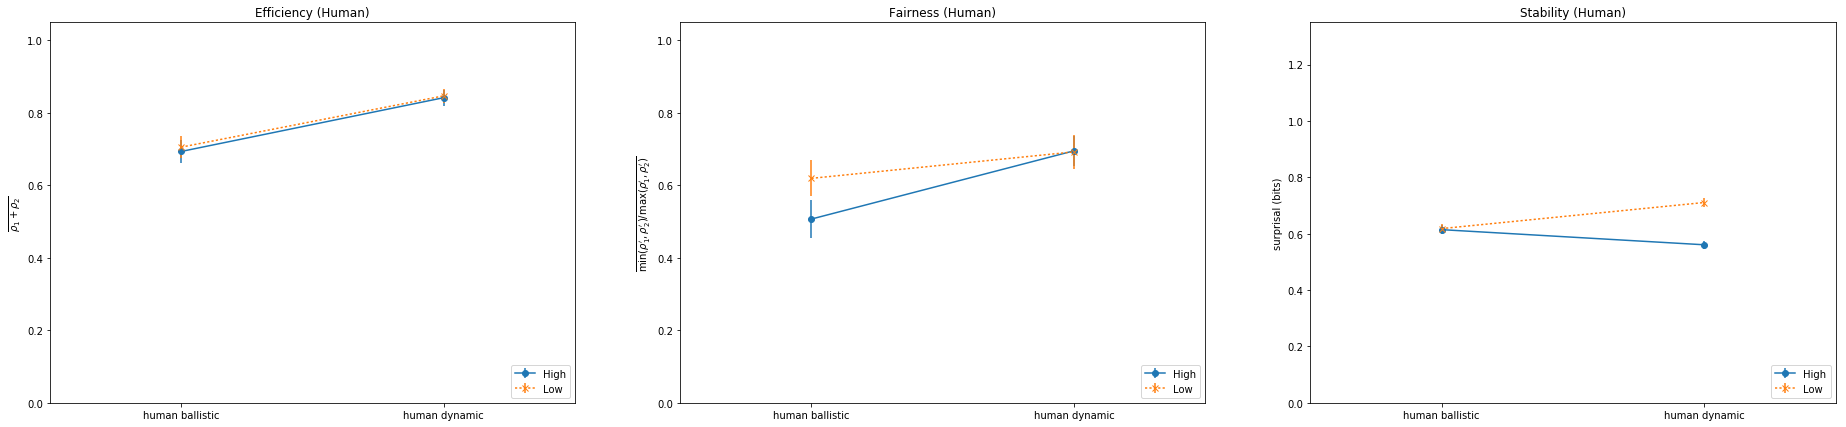

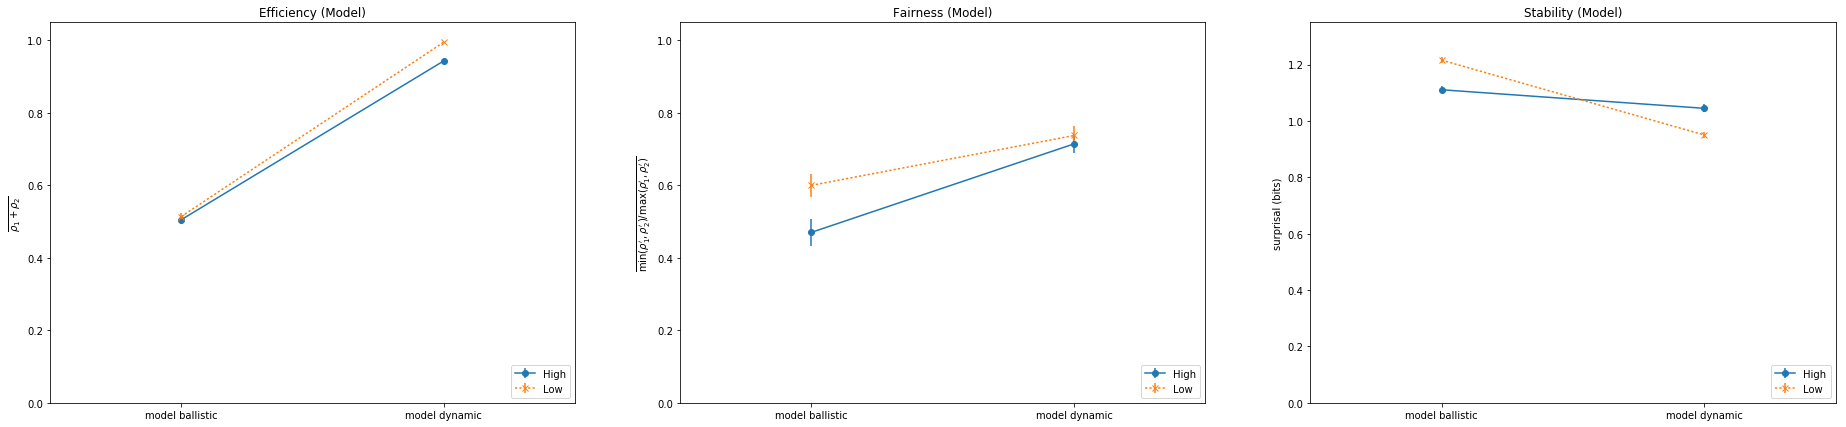

In [31]:
p1 = plt.figure(1);
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(32,7)


plt.subplot(131)
plt.errorbar([0,1], [np.mean(h_human_bal_eff), np.mean(h_human_dyn_eff)], 
             yerr = [np.std(h_human_bal_eff) / math.sqrt(len(h_human_bal_eff)),
                     np.std(h_human_dyn_eff) / math.sqrt(len(h_human_dyn_eff))], 
             fmt='-o',  label = "High")
plt.errorbar([0,1], [np.mean(l_human_bal_eff), np.mean(l_human_dyn_eff)], 
             yerr = [np.std(l_human_bal_eff) / math.sqrt(len(l_human_bal_eff)),
                     np.std(l_human_dyn_eff) / math.sqrt(len(l_human_dyn_eff))], 
             fmt = ':x', label = "Low")
plt.xticks([0,1],['human ballistic', 'human dynamic'])
plt.xlim(-0.5, 1.5)
plt.ylim(0.00, 1.05)
plt.legend(loc='lower right')
plt.ylabel(r"$\overline{\rho_1 + \rho_2}$")
plt.title("Efficiency (Human)")


plt.subplot(132)
plt.errorbar([0,1], [np.mean(h_human_bal_fair), np.mean(h_human_dyn_fair)], 
             yerr = [np.std(h_human_bal_fair) / math.sqrt(len(h_human_bal_fair)),
                     np.std(h_human_dyn_fair) / math.sqrt(len(h_human_dyn_fair))], 
             fmt='-o',  label = "High")
plt.errorbar([0,1], [np.mean(l_human_bal_fair), np.mean(l_human_dyn_fair)], 
             yerr = [np.std(l_human_bal_fair) / math.sqrt(len(l_human_bal_fair)),
                     np.std(l_human_dyn_fair) / math.sqrt(len(l_human_dyn_fair))], 
             fmt = ':x', label = "Low")
plt.xticks([0,1],['human ballistic', 'human dynamic'])
plt.xlim(-0.5, 1.5)
plt.ylim(0.00, 1.05)
plt.legend(loc='lower right')
plt.ylabel(r"$\overline{\min(\rho_1', \rho_2') / \max(\rho_1', \rho_2')}$")
plt.title("Fairness (Human)")


plt.subplot(133)
plt.errorbar([0,1], [np.mean(h_human_bal_surp), np.mean(h_human_dyn_surp)], 
             yerr = [np.std(h_human_bal_surp) / math.sqrt(len(h_human_bal_surp)),
                     np.std(h_human_dyn_surp) / math.sqrt(len(h_human_dyn_surp))], 
             fmt='-o',  label = "High")
plt.errorbar([0,1], [np.mean(l_human_bal_surp), np.mean(l_human_dyn_surp)], 
             yerr = [np.std(l_human_bal_surp) / math.sqrt(len(l_human_bal_surp)),
                     np.std(l_human_dyn_surp) / math.sqrt(len(l_human_dyn_surp))],
             fmt = ':x', label = "Low")
plt.xticks([0,1],['human ballistic', 'human dynamic'])
plt.xlim(-0.5, 1.5)
plt.ylim(0.00, 1.35)
plt.legend(loc='lower right')
plt.ylabel(r"surprisal (bits)")
plt.title("Stability (Human)")

p2 = plt.figure(2);
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(32,7)


plt.subplot(131)
plt.errorbar([0,1], [np.mean(h_model_bal_eff), np.mean(h_model_dyn_eff)], 
             yerr = [np.std(h_model_bal_eff) / math.sqrt(len(h_model_bal_eff)),
                     np.std(h_model_dyn_eff) / math.sqrt(len(h_model_dyn_eff))], 
             fmt='-o',  label = "High")
plt.errorbar([0,1], [np.mean(l_model_bal_eff), np.mean(l_model_dyn_eff)], 
             yerr = [np.std(l_model_bal_eff) / math.sqrt(len(l_model_bal_eff)),
                     np.std(l_model_dyn_eff) / math.sqrt(len(l_model_dyn_eff))], 
             fmt = ':x', label = "Low")
plt.xticks([0,1],['model ballistic', 'model dynamic'])
plt.xlim(-0.5, 1.5)
plt.ylim(0.00, 1.05)
plt.legend(loc='lower right')
plt.ylabel(r"$\overline{\rho_1 + \rho_2}$")
plt.title("Efficiency (Model)")


plt.subplot(132)
plt.errorbar([0,1], [np.mean(h_model_bal_fair), np.mean(h_model_dyn_fair)], 
             yerr = [np.std(h_model_bal_fair) / math.sqrt(len(h_model_bal_fair)),
                     np.std(h_model_dyn_fair) / math.sqrt(len(h_model_dyn_fair))], 
             fmt='-o',  label = "High")
plt.errorbar([0,1], [np.mean(l_model_bal_fair), np.mean(l_model_dyn_fair)], 
             yerr = [np.std(l_model_bal_fair) / math.sqrt(len(l_model_bal_fair)),
                     np.std(l_model_dyn_fair) / math.sqrt(len(l_model_dyn_fair))], 
             fmt = ':x', label = "Low")
plt.xticks([0,1],['model ballistic', 'model dynamic'])
plt.xlim(-0.5, 1.5)
plt.ylim(0.00, 1.05)
plt.legend(loc='lower right')
plt.ylabel(r"$\overline{\min(\rho_1', \rho_2') / \max(\rho_1', \rho_2')}$")
plt.title("Fairness (Model)")


plt.subplot(133)
plt.errorbar([0,1], [np.mean(h_model_bal_surp), np.mean(h_model_dyn_surp)], 
             yerr = [np.std(h_model_bal_surp) / math.sqrt(len(h_model_bal_surp)),
                     np.std(h_model_dyn_surp) / math.sqrt(len(h_model_dyn_surp))], 
             fmt='-o',  label = "High")
plt.errorbar([0,1], [np.mean(l_model_bal_surp), np.mean(l_model_dyn_surp)], 
             yerr = [np.std(l_model_bal_surp) / math.sqrt(len(l_model_bal_surp)),
                     np.std(l_model_dyn_surp) / math.sqrt(len(l_model_dyn_surp))],
             fmt = ':x', label = "Low")
plt.xticks([0,1],['model ballistic', 'model dynamic'])
plt.xlim(-0.5, 1.5)
plt.ylim(0.00, 1.35)
plt.legend(loc='lower right')
plt.ylabel(r"surprisal (bits)")
plt.title("Stability (Model)")

#matplotlib.rcParams.update({'font.size': 25})
pp = PdfPages("../data/figures/Compared_All.pdf")
pp.savefig(p1, dpi = 300, transparent = True)
pp.savefig(p2, dpi = 300, transparent = True)
pp.close()